In [29]:
import numpy as np
import matplotlib.pyplot as plt
import SQcircuit as sq
import Modules.SQcircuit_extensions as sq_ext
from scipy.optimize import curve_fit, minimize

import pickle
import os
import importlib
importlib.reload(sq_ext)


<module 'Modules.SQcircuit_extensions' from '/home/gabriel/PycharmProjects/tunable-capacitive-coupling-flux-qubits/Modules/SQcircuit_extensions.py'>

In [2]:
data_dir = r'/data'

In [3]:
with open(os.getcwd() + data_dir + r'/f_vna__fs_rough_q1_coil1.pkl', 'rb') as f:
    f_vna__fs_rough_q1_coil1 = pickle.load(f)
with open(os.getcwd() + data_dir + r'/current__fs_rough_q1_coil1.pkl', 'rb') as f:
    current__fs_rough_q1_coil1 = pickle.load(f)
with open(os.getcwd() + data_dir + r'/phase__fs_rough_q1_coil1.pkl', 'rb') as f:
    phase__fs_rough_q1_coil1 = pickle.load(f)

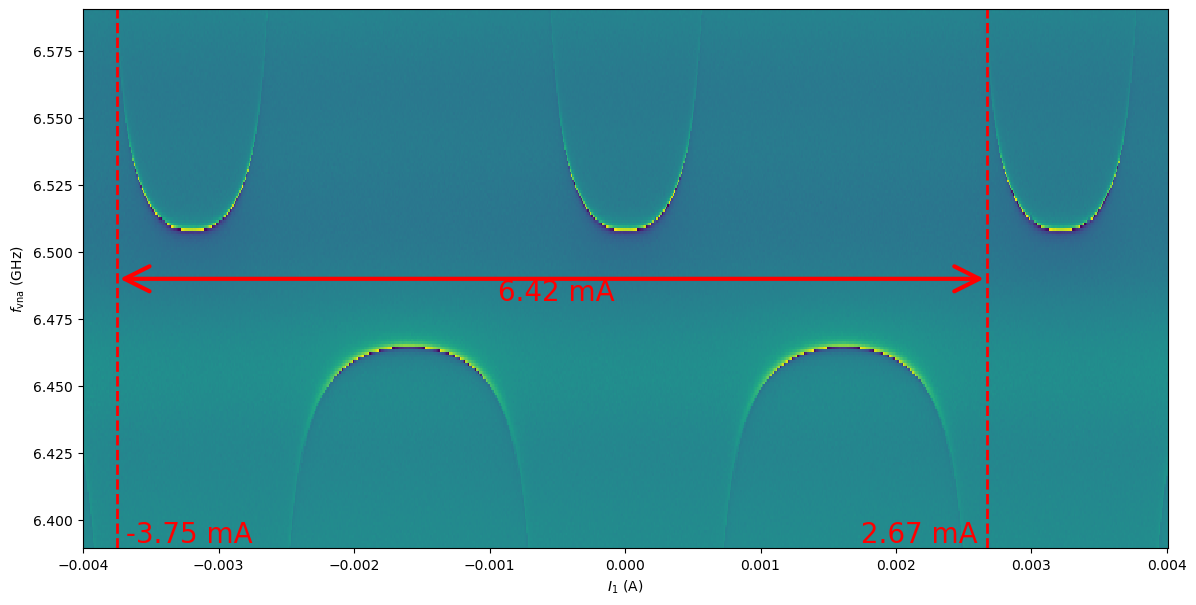

I0__q1 = 3.21 mA


In [4]:
fig,ax = plt.subplots(1,1,figsize = (14,7))

ax.pcolor(current__fs_rough_q1_coil1, f_vna__fs_rough_q1_coil1*1e-9, phase__fs_rough_q1_coil1.T, shading = 'auto')

I_ss_low__fs = -0.00375
ax.axvline(x=I_ss_low__fs,color='red',ls='--',lw=2)
ax.text(s=' {} mA'.format(round(I_ss_low__fs*1e3,3)), x=I_ss_low__fs, y=ax.get_ylim()[0], ha='left', va='bottom', color ='red',
        size=20)

I_ss_up__fs = 0.00267
ax.axvline(x=I_ss_up__fs,color='red',ls='--',lw=2)
ax.text(s=' {} mA '.format(round(I_ss_up__fs*1e3,3)), x=I_ss_up__fs, y=ax.get_ylim()[0], ha='right', va='bottom', color ='red',
        size=20)

Anzahl_Perioden = 2
I0_q1 = (I_ss_up__fs - I_ss_low__fs)/Anzahl_Perioden


ax.annotate(xy=(I_ss_low__fs,np.mean(ax.get_ylim())),xytext=(I_ss_up__fs,np.mean(ax.get_ylim())), text='', arrowprops=dict(arrowstyle='<->,head_length=1.8,head_width=0.9',
                                        lw=3,color='red'))
ax.text(s=' {} mA'.format(round(I0_q1*1e3*Anzahl_Perioden,5)), x=I_ss_low__fs+I0_q1/2*Anzahl_Perioden, y=np.mean(ax.get_ylim()), ha='center', va='top', color ='red',
        size=20)

ax.set_xlabel(r'$I_1$ (A)')
ax.set_ylabel(r'$f_{\rm vna}$ (GHz)')
plt.show()

print('I0__q1 = {} mA'.format(I0_q1*1e3))

In [5]:
with open(os.getcwd() + data_dir + r'/x__q1_tt_low_q1.pkl', 'rb') as f:
    x__q1_tt_low = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/y__q1_tt_low_q1.pkl', 'rb') as f:
    y__q1_tt_low = pickle.load(f)[0]
    
with open(os.getcwd() + data_dir + r'/x__q1_tt_up_q1.pkl', 'rb') as f:
    x__q1_tt_up = pickle.load(f)
with open(os.getcwd() + data_dir + r'/y__q1_tt_up_q1.pkl', 'rb') as f:
    y__q1_tt_up = pickle.load(f)

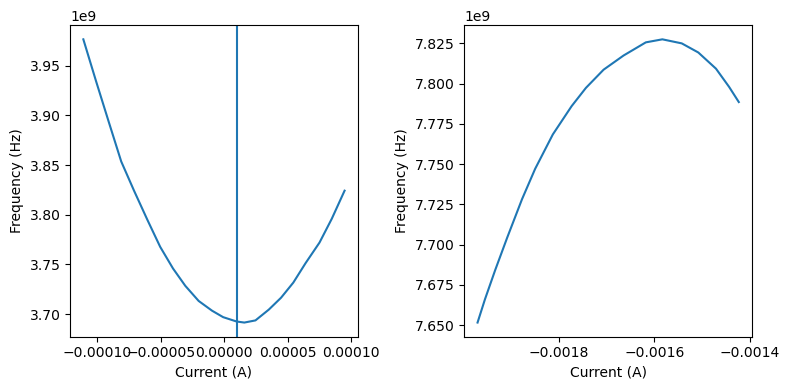

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].plot(x__q1_tt_low, y__q1_tt_low )
ax[0].axvline(1e-5)
I_ss__q1_tt_low = 1e-5

ax[1].plot(x__q1_tt_up, y__q1_tt_up )

ax[0].set_ylabel('Frequency (Hz)')
ax[1].set_ylabel('Frequency (Hz)')

ax[0].set_xlabel('Current (A)')
ax[1].set_xlabel('Current (A)')

fig.tight_layout()

In [7]:
x__q1_tt = np.concatenate([x__q1_tt_low, x__q1_tt_up])
y__q1_tt = np.concatenate([y__q1_tt_low, y__q1_tt_up])

In [8]:
phi_q1_tt = (x__q1_tt - I_ss__q1_tt_low + I0_q1/2  ) /I0_q1

Text(0.5, 0, '$\\phi_{ext}$ ($\\phi_0$)')

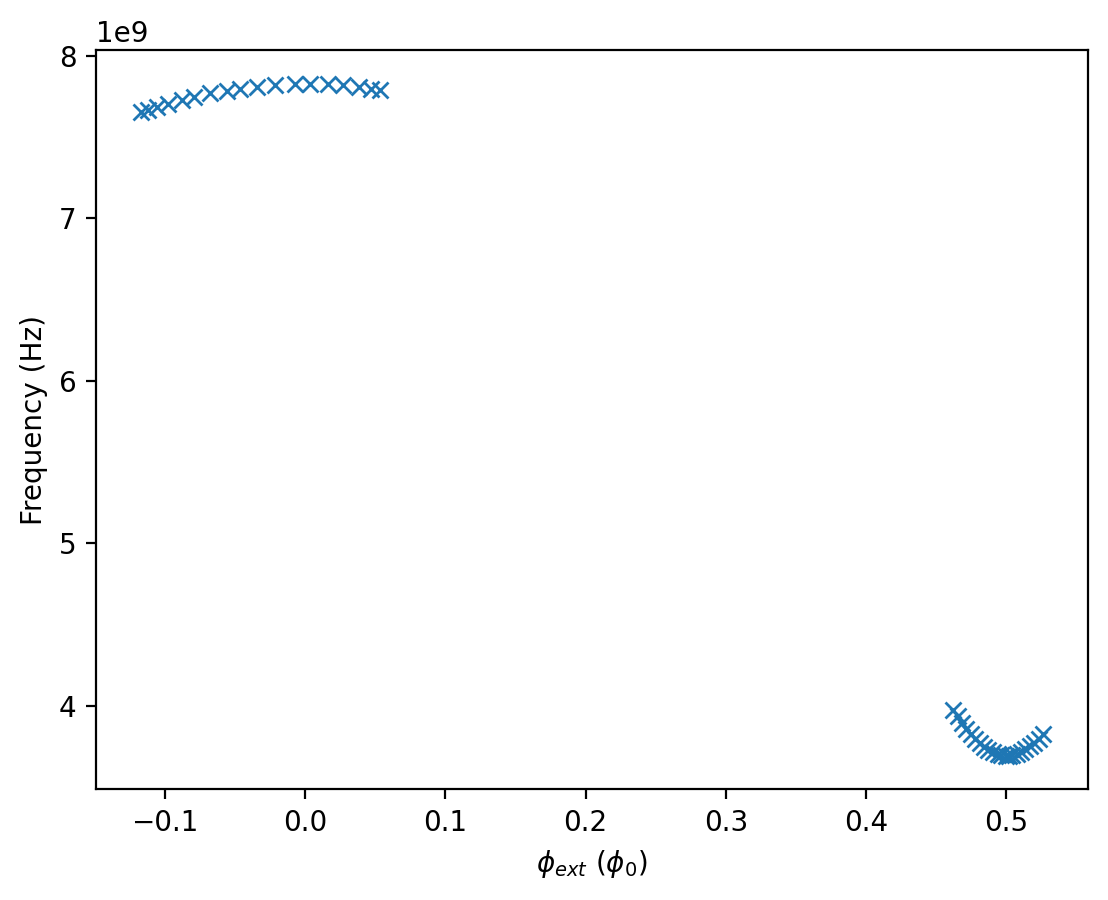

In [10]:
fig, ax = plt.subplots(dpi=200)
ax.plot(phi_q1_tt, y__q1_tt, 'x')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

In [62]:
CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, ω_r_1 = sq_ext.get_experimental_parameters('qubit 1', Δ=0.1, LR=100)
parameters_qubit_1 = [CF_1, LF_1, EJ_1]
parameters_qubit_1

[26.9, 26.5, 5.4]

## Fit the model to the data using curve fit

In [64]:
bounds_qubit_1_curve_fit = ([20, 20, 4],[30, 30, 15])

In [65]:
def fluxonium_spectrum(φ_ext_values, CF, LF, EJ):
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ)
    loop  = fluxonium.loops[0]
    ω_vs_φ_ext = np.zeros(len(φ_ext_values))
    
    for i, φ_ext in enumerate(φ_ext_values):
        loop.set_flux(φ_ext)
        fluxonium.diag(2)
        ω_vs_φ_ext[i] = fluxonium.efreqs[1]-fluxonium.efreqs[0]
        
    return ω_vs_φ_ext * 1e9

In [66]:
parameters_qubit_1_curve_fit, params_covariance = curve_fit(fluxonium_spectrum, phi_q1_tt, y__q1_tt, p0=parameters_qubit_1, bounds=bounds_qubit_1_curve_fit)

In [67]:
parameters_qubit_1_curve_fit

array([28.46191695, 25.0317741 ,  5.63484746])

In [69]:
def fluxonium_spectrum_minus_data(x):
    CF, LF, EJ = x
    φ_ext_values = phi_q1_tt
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ)
    loop  = fluxonium.loops[0]
    ω_vs_φ_ext = np.zeros(len(φ_ext_values))
    
    for i, φ_ext in enumerate(φ_ext_values):
        loop.set_flux(φ_ext)
        fluxonium.diag(2)
        ω_vs_φ_ext[i] = fluxonium.efreqs[1]-fluxonium.efreqs[0]
        
    return np.sum((ω_vs_φ_ext * 1e9 - y__q1_tt)**2)

## Fit the model to the data using minimize

In [71]:
bounds_qubit_1 = ((20,30), (20,30), (4,15))

In [72]:
# Fit the model to the data using minimize
result = minimize(fluxonium_spectrum_minus_data, parameters_qubit_1, bounds=bounds_qubit_1)

In [73]:
parameters_qubit_1_minimize = result.x
parameters_qubit_1_minimize

array([28.46176238, 25.03191486,  5.63482421])

## Plot fits and errors

In [74]:
ω_qubit_1_vs_φ_ext           = fluxonium_spectrum(phi_q1_tt, *parameters_qubit_1)
ω_qubit_1_vs_φ_ext_curve_fit = fluxonium_spectrum(phi_q1_tt, *parameters_qubit_1_curve_fit)
ω_qubit_1_vs_φ_ext_minimize =  fluxonium_spectrum(phi_q1_tt, *parameters_qubit_1_minimize)

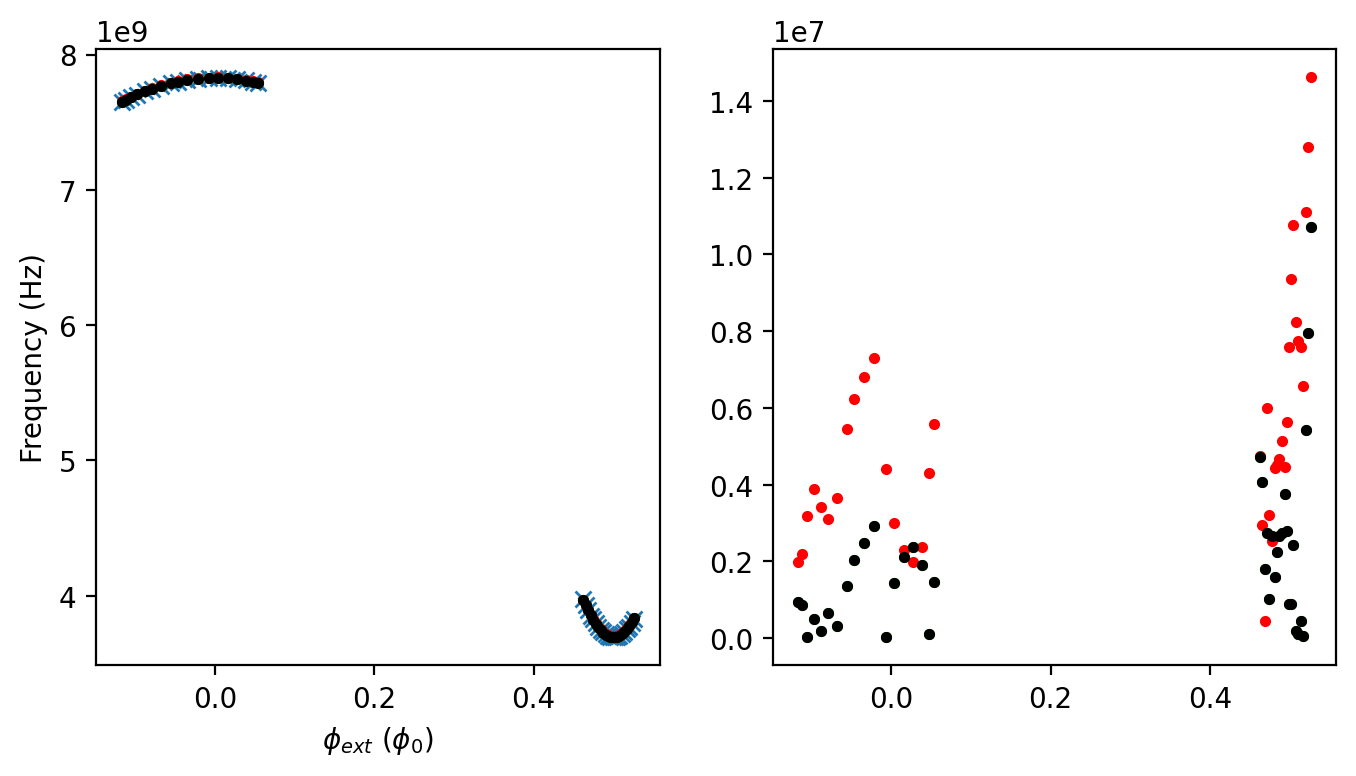

In [75]:
fig, (ax1, ax2 )= plt.subplots(ncols=2, dpi=200, figsize=[8,4])
ax1.plot(phi_q1_tt, y__q1_tt, 'x')
ax1.plot(phi_q1_tt, ω_qubit_1_vs_φ_ext, 'r.')
ax1.plot(phi_q1_tt, ω_qubit_1_vs_φ_ext_curve_fit, 'g.')
ax1.plot(phi_q1_tt, ω_qubit_1_vs_φ_ext_minimize, 'k.')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

ax2.plot(phi_q1_tt, np.abs(ω_qubit_1_vs_φ_ext-y__q1_tt), 'r.')
ax2.plot(phi_q1_tt, np.abs(ω_qubit_1_vs_φ_ext_curve_fit-y__q1_tt), 'g.')
ax2.plot(phi_q1_tt, np.abs(ω_qubit_1_vs_φ_ext_minimize-y__q1_tt), 'k.')

# Qubit 1 - resonator 1 avoided level crossing

In [82]:
with open(os.getcwd() + data_dir + r'/f_vna__fs_q1_coil1.pkl', 'rb') as f:
    f_vna__fs_q1_coil1 = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/current__fs_q1_coil1.pkl', 'rb') as f:
    current__fs_q1_coil1 = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/phase__fs_q1_coil1.pkl', 'rb') as f:
    phase__fs_q1_coil1 = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/current__fres_q1_coil1.pkl', 'rb') as f:
    current_q1_coil1 = pickle.load(f)
with open(os.getcwd() + data_dir + r'/fres__fres_q1_coil1.pkl', 'rb') as f:
    fres_q1_coil1 = pickle.load(f)
    
current_q1_coil1 = np.concatenate([current_q1_coil1[0], current_q1_coil1[1], current_q1_coil1[2]])
fres_q1_coil1 = np.concatenate([fres_q1_coil1[0], fres_q1_coil1[1], fres_q1_coil1[2]])

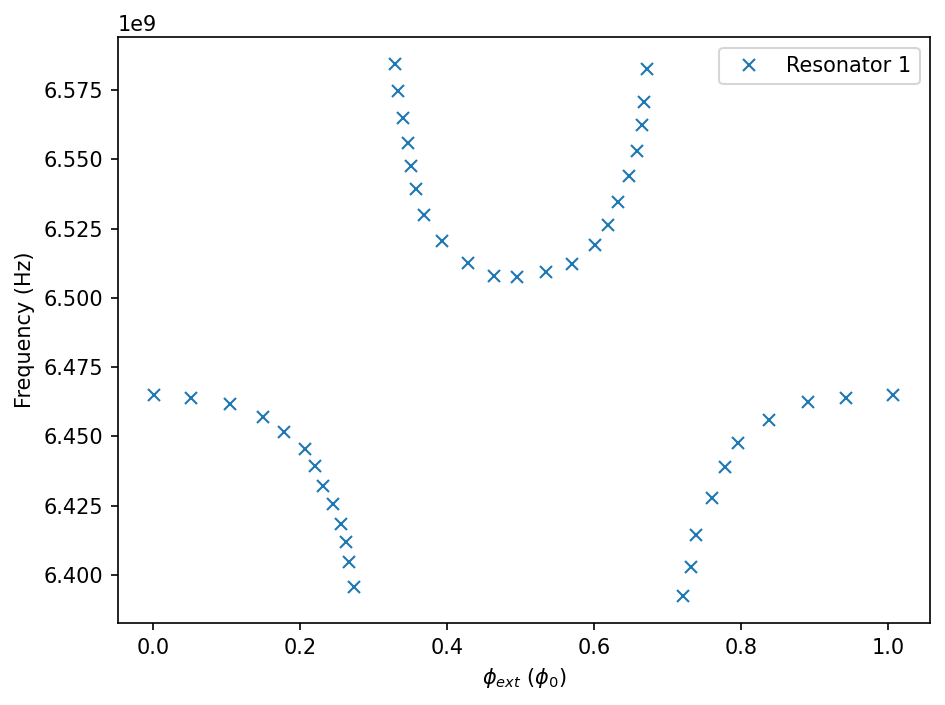

In [83]:
I_ss__q1_fs = 1.12*1e-5
phi_q1_coil1 = (current_q1_coil1 - I_ss__q1_fs + I0_q1 / 2) / I0_q1

fig, ax = plt.subplots(dpi=150)
ax.plot(phi_q1_coil1, fres_q1_coil1, marker='x', ls='', label='Resonator 1')

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax.legend()
fig.tight_layout()

In [84]:
CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, ω_r_1 = sq_ext.get_experimental_parameters('qubit 1', Δ=0.1, LR=100)
CR_2, CF_2, LF_2, LR_2, EJ_2, Δ_2, ω_r_2 = sq_ext.get_experimental_parameters('qubit 2', Δ=0.1, LR=100)

In [119]:
def resonator_qubit_avoided_crossing_spectrum(φ_ext_values, CR, LR, EJ, Δ, C_int):
    CF_1, LF_1, EJ_1 = parameters_qubit_1_curve_fit

    resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR)
    qubit = sq_ext.sq_fluxonium(C_F_eff=CF_1, L_F_eff=LF_1, EJ=EJ, Δ=Δ)
    loop  = qubit.loops[0]
    Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF_1,LR=LR,Δ=Δ)

    ω_vs_φ_ext = np.zeros([len(φ_ext_values),2])

    for i, φ_ext in enumerate(φ_ext_values):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ, C_int=C_int )
        ω_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
        
    return np.concatenate( [ω_vs_φ_ext[0:13,0] , ω_vs_φ_ext[13:-10,1], ω_vs_φ_ext[-10:,0]]) * 1e9

In [135]:
Δ = 0.8
EJ = parameters_qubit_1_curve_fit[-1]
LR = 100
C_int = 370
CR, _, _, _, _, _, _ = sq_ext.get_experimental_parameters('qubit 1', Δ=Δ, LR=LR)
CR-=0.05
LR-=0.3
paramters_resonator_qubit_1_avoided_crossing = [CR, LR, EJ, Δ, C_int]
bounds_resonator_qubit_1_avoided_crossing = ([2,30,4,0,10],[25,170,15,1,1000])
ω_resonator_qubit_1_avoided_crossing_vs_φ_ext = resonator_qubit_avoided_crossing_spectrum(phi_q1_coil1, *paramters_resonator_qubit_1_avoided_crossing)

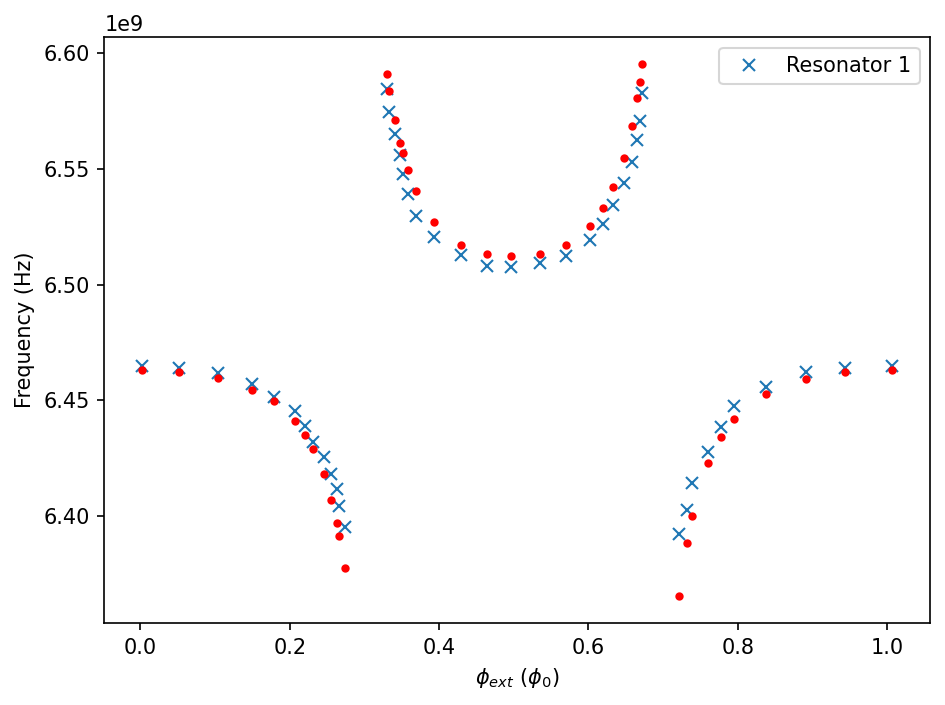

In [136]:
fig, ax = plt.subplots(dpi=150)
ax.plot(phi_q1_coil1, fres_q1_coil1, marker='x', ls='', label='Resonator 1')
ax.plot(phi_q1_coil1, ω_resonator_qubit_1_avoided_crossing_vs_φ_ext, '.r')

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax.legend()
fig.tight_layout()

In [137]:
parameters_resonator_qubit_1_avoided_crossing_opt, params_covariance =\
    curve_fit(resonator_qubit_avoided_crossing_spectrum, phi_q1_coil1, fres_q1_coil1, p0=paramters_resonator_qubit_1_avoided_crossing, bounds=bounds_resonator_qubit_1_avoided_crossing)

In [138]:
parameters_resonator_qubit_1_avoided_crossing_opt

array([6.20734087e+00, 9.66049334e+01, 5.72983605e+00, 1.11298616e-01,
       2.38558052e+02])

In [139]:
paramters_resonator_qubit_1_avoided_crossing

[6.019811823794066, 99.7, 5.634847463548342, 0.8, 370]

In [140]:
ω_resonator_qubit_1_avoided_crossing_vs_φ_ext_opt = resonator_qubit_avoided_crossing_spectrum(phi_q1_coil1, *parameters_resonator_qubit_1_avoided_crossing_opt)

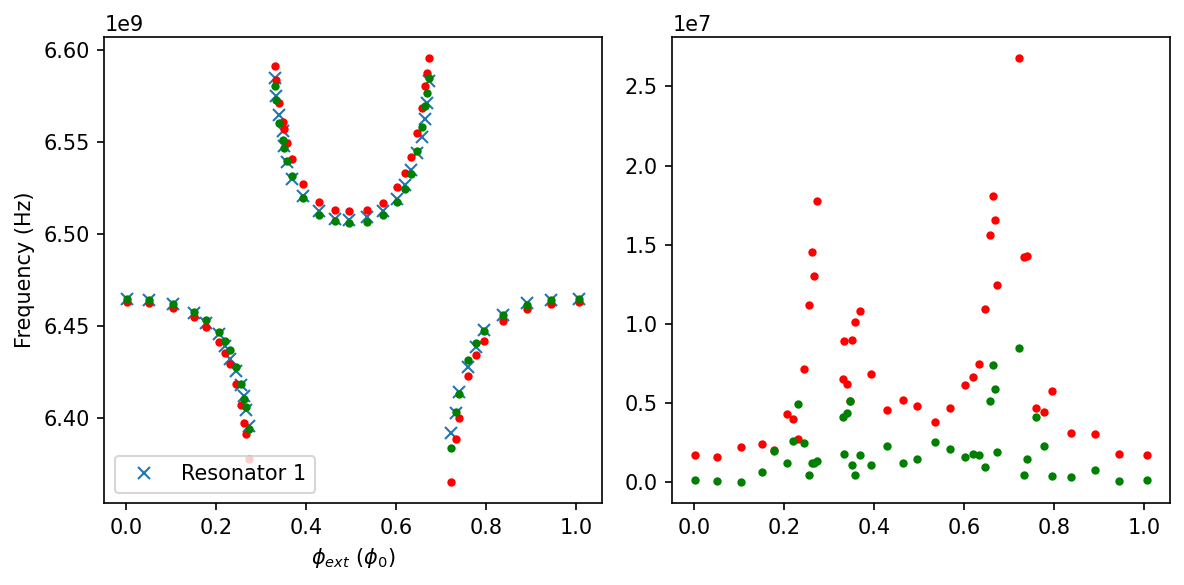

In [143]:
fig, (ax, ax2) = plt.subplots(ncols=2, dpi=150, figsize=[8,4])
ax.plot(phi_q1_coil1, fres_q1_coil1, marker='x', ls='', label='Resonator 1')
ax.plot(phi_q1_coil1, ω_resonator_qubit_1_avoided_crossing_vs_φ_ext, '.r')
ax.plot(phi_q1_coil1, ω_resonator_qubit_1_avoided_crossing_vs_φ_ext_opt, '.g')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax.legend()

ax2.plot(phi_q1_coil1, np.abs(ω_resonator_qubit_1_avoided_crossing_vs_φ_ext-fres_q1_coil1), '.r')
ax2.plot(phi_q1_coil1, np.abs(ω_resonator_qubit_1_avoided_crossing_vs_φ_ext_opt-fres_q1_coil1), '.g')
fig.tight_layout()